# Movie Classification using Naive Bayes Classifier

## 1. Data
The dataset is composed of 3 files.

* **movies.dat** - movie information (title and genre)
* **users.dat** - user information (including gender, age, occupation...)
* **ratings.dat** - movie ratings given by users

In [2]:
import pandas as pd
import numpy as np

from IPython.display import display, HTML

In [3]:
DATA_PATH = "../data"

data_movies = pd.read_csv(DATA_PATH + "/movies.dat", delimiter="::", header=None, engine="python",
                         names=["MovieID", "Title", "Genres"])

data_users = pd.read_csv(DATA_PATH + "/users.dat", delimiter="::", header=None, engine="python",
                         names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

data_ratings = pd.read_csv(DATA_PATH + "/ratings.dat", delimiter="::", header=None, engine="python",
                         names=["UserID", "MovieID", "Rating", "Timestamp"])


Some simple data visualization...

In [4]:
print ("Movies dataset")
display(data_movies.head())
display(data_movies.info())

Movies dataset


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
MovieID    3883 non-null int64
Title      3883 non-null object
Genres     3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


None

In [5]:
print ("Users dataset")
display(data_users.head())
display(data_users.info())

Users dataset


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 5 columns):
UserID        6042 non-null int64
Gender        6042 non-null object
Age           6042 non-null int64
Occupation    6042 non-null int64
Zip-code      6042 non-null object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


None

In [6]:
print ("Ratings dataset")
display(data_ratings.head())
display(data_ratings.info())

Ratings dataset


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000249 entries, 0 to 1000248
Data columns (total 4 columns):
UserID       1000249 non-null int64
MovieID      1000249 non-null int64
Rating       1000249 non-null int64
Timestamp    1000249 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


None

In [41]:
#Data cleaning

#Joining df
data = pd.merge(data_ratings, data_users, how="inner", on="UserID")
data = pd.merge(data, data_movies, how="inner", on="MovieID")


In [42]:
#Feature Extraction

def get_genre_id(genres_list):
    """
    return the integer id of a list of genres, 
    which is the integer corresponding to the binary intersection of the list with all the genres
    """
    # movie genres
    genres = [
        'Action',
        'Adventure',
        'Animation',
        'Children\'s',
        'Comedy',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western'
    ]
    # creating id
    id = 0
    weight = 1
    for genre in genres:
        if genre in genres_list:
            id += weight
        weight*=2
    return id


data['GenresProcessed'] = data['Genres'].apply(get_genre_id)
data['GenderProcessed'] = data['Gender'].apply(lambda x: 0 if x == 'M' else 1)

#Droping unwanted columns
#data = data.drop("Zip-code", 1)
#data = data.drop("Timestamp", 1)
#data = data.drop("Title", 1)
#data = data.drop("MovieID", 1)
#data = data.drop("UserID", 1)
columns = ['UserID', 'MovieID', 'Rating', 'GenderProcessed', 'Age', 'Occupation', 'GenresProcessed']
data = data[columns]


display(data.head())


,UserID,MovieID,Rating,GenderProcessed,Age,Occupation,GenresProcessed
0,1,1193,5,1,1,10,64
1,2,1193,5,0,56,16,64
2,12,1193,4,0,25,12,64
3,15,1193,4,0,25,7,64
4,17,1193,5,0,50,1,64


### Train/Validation/Test split

We now construct a function to split our dataset into three different sets:

- A training set, which will be used to build the classifiers
- A validation set, which will be used to determine the best hyperparameters of the classifiers (for example, the maximum depth of the three)
- A test set, which will be used to measure the performance

We will randomly construct the sets, and we will spit the sets with 60%, 20% and 20% of the shuffled data, respectively for the trainig, validation and test sets.

In [43]:
def dataset_split(df, label_name, train_size=0.6, validation_size=0.2):
    """
    splits the data into training, validation and test sets
    """
    
    # empty dataframes
    train_set = pd.DataFrame(columns=list(df.columns))
    validation_set = pd.DataFrame(columns=list(df.columns))
    test_set = pd.DataFrame(columns=list(df.columns))
    
    # stratify sampling
    labels = df[label_name].unique()
    for label in labels:
        label_df = df.ix[df[label_name] == label]
        label_df = label_df.sample(frac=1) #randomize
        size = len(label_df.index)
        validation_start = int(train_size*size)
        test_start = int((train_size+validation_size)*size)
        train_set = pd.concat([train_set, label_df[:validation_start]])
        validation_set = pd.concat([validation_set, label_df[validation_start:test_start]])
        test_set = pd.concat([test_set, label_df[test_start:]])
    
    # randomizing
    train_set = train_set.sample(frac=1)
    validation_set = validation_set.sample(frac=1)
    test_set = test_set.sample(frac=1)
    
    return train_set, validation_set, test_set

train_set, validation_set, test_set = dataset_split(data,'Rating')

#Convert rating to int
train_set[columns] = train_set[columns].astype(int)
validation_set[columns] = validation_set[columns].astype(int)
test_set[columns] = test_set[columns].astype(int)

print ("Training set size: " + str(len(train_set.index)))
print ("Validation set size: " + str(len(validation_set.index)))
print ("Test set size: " + str(len(test_set.index)))


Training set size: 600148
Validation set size: 200050
Test set size: 200051


In [14]:
data['Rating'].unique()

array([5, 4, 3, 2, 1])

### Naive Bayes Classifier

Using the naive bayes classifier implemented in classifier.py, we get:

In [74]:
from classifier import NaiveBayesClassifier

trainX = train_set.drop(['Rating', 'UserID', 'MovieID', 'GenresProcessed'], axis=1).values
trainY = train_set['Rating'].values

# display(trainX)
# display(trainY)
# display(np.shape(trainX))
# display(np.shape(trainY))
# display(np.unique(trainY))

nb = NaiveBayesClassifier()

nb.fit(trainX, trainY)


print ("Classifier trained.")

1 0 {0: 0.7604141941609305, 1: 0.23958580583906955}
1 1 {50: 0.053257773558034655, 1: 0.04097436506052694, 18: 0.2334441015903157, 35: 0.16149418466650842, 56: 0.028186565392831712, 25: 0.4215820080702587, 45: 0.06106100166152385}
1 2 {0: 0.13924163304058865, 1: 0.08375860431996202, 2: 0.0552159981011156, 3: 0.026732732019938286, 4: 0.16279966769522905, 5: 0.018692143365772608, 6: 0.03652385473534299, 7: 0.09138381201044386, 8: 0.003026347021125089, 9: 0.00682411583194873, 10: 0.03765131735105626, 11: 0.023736055067647758, 12: 0.044683123664846905, 13: 0.0075955376216472826, 14: 0.041449086161879894, 15: 0.01649655827201519, 16: 0.03515903156895324, 17: 0.058835746498931876, 18: 0.010325183954426774, 19: 0.02610966057441253, 20: 0.0737597911227154}
2 0 {0: 0.771035423187777, 1: 0.22896457681222301}
2 1 {50: 0.055583103480335946, 1: 0.02809371804010289, 18: 0.20683670623237363, 35: 0.18817987417485357, 56: 0.02820218799392568, 25: 0.41587380295658105, 45: 0.07723060712182725}
2 2 {0: 0.

In [71]:
#Show results for user 6041 and 6042
print (" Predicting ratings for all movies seen by users 6041 and 6042...")
rows = data.ix[data['UserID'].isin([6041,6042])]

for _, row in rows.iterrows():
    row_pred = row.drop(['Rating', 'UserID', 'MovieID', 'GenresProcessed'])
    #display(row.shape)
    #display(row.values)
    prediction = nb.predict(np.array([row_pred.values]))
    print ("Tree prediction for user " + str(row['UserID']) + " and movie " + str(row['MovieID']) + ": ", str(prediction[0][0]))


 Predicting ratings for all movies seen by users 6041 and 6042...
Tree prediction for user 6041 and movie 527:  4.0
Tree prediction for user 6042 and movie 527:  4.0
Tree prediction for user 6041 and movie 260:  4.0
Tree prediction for user 6042 and movie 260:  4.0
Tree prediction for user 6041 and movie 608:  4.0
Tree prediction for user 6042 and movie 608:  4.0
Tree prediction for user 6041 and movie 1246:  4.0
Tree prediction for user 6042 and movie 1246:  4.0
Tree prediction for user 6041 and movie 1225:  4.0
Tree prediction for user 6042 and movie 1225:  4.0
Tree prediction for user 6041 and movie 318:  4.0
Tree prediction for user 6042 and movie 318:  4.0
Tree prediction for user 6041 and movie 215:  4.0
Tree prediction for user 6042 and movie 215:  4.0
Tree prediction for user 6041 and movie 47:  4.0
Tree prediction for user 6042 and movie 47:  4.0
Tree prediction for user 6041 and movie 296:  4.0
Tree prediction for user 6042 and movie 296:  4.0
Tree prediction for user 6041 an

## Measuring performance

Lets build some usefull functions to better measure the performance of a classifier. First of all, 
we'll build a function to plot the confusion matrix in a more user friendly display let's test this with the confusion matrix from the classifier we built above, for the test set.



Predicting ratings for test set. This may take a while...
Done. Plotting the confusion matrix


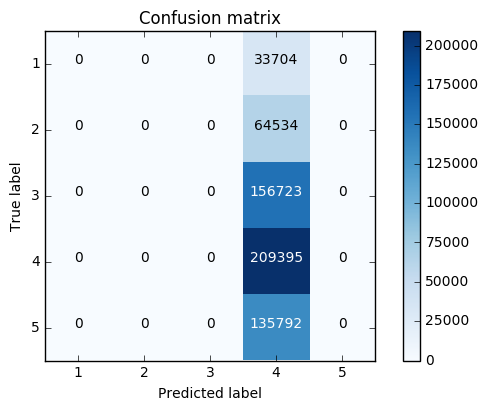

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(matrix_in, classes, cmap=plt.cm.Blues):
    classes.sort()
    matrix = []
    for s_class in classes:
        row = []
        for o_class in classes:
            row.append(matrix_in[o_class][s_class])
        matrix.append(row)
    cm = np.array(matrix, dtype=int)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks,classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
X_test = train_set.drop(['Rating', 'UserID', 'MovieID', 'GenresProcessed'], axis=1).values
Y_test = train_set['Rating'].values
labels = data['Rating'].unique()

print ("Predicting ratings for test set. This may take a while...")
confusion_matrix = nb.score(X_test, Y_test, labels)
print ("Done. Plotting the confusion matrix")
plot_confusion_matrix(confusion_matrix, labels)

In [10]:
data.drop("Genres", 1)
data = data.drop("MovieID", 1)
data = data.drop("UserID", 1)



ValueError: labels ['MovieID'] not contained in axis

### Calculating scores

We will now build a function that, given a confusion matrix, computes the accuracy, mean square error and Kappa score.

In [77]:
def get_statistics(confusion_matrix, labels): 
    """
    compute accuracy, mean square error and kappa 
    """
    total = 0.0
    rights = 0.0
    error = 0.0
    true_totals = np.zeros(len(labels)+1)
    predict_totals = np.zeros(len(labels)+1)
    for true_label in labels:
        for predicted_label in labels:
            current_val = confusion_matrix[predicted_label][true_label]
            total += current_val
            error += abs(true_label-predicted_label)**2 * current_val
            predict_totals[int(predicted_label)] += current_val
            true_totals[int(true_label)] += current_val
        rights += confusion_matrix[true_label][true_label]
    accuracy = rights/total
    error /= total
    
    ef = 0.0
    for label in labels:
        ef += true_totals[int(label)]*predict_totals[int(label)]/total
    K = (rights-ef)/(total-ef)
    return accuracy, error, K

accuracy, error, kappa = get_statistics(confusion_matrix, labels)
print ("Accuracy:", accuracy)
print ("Mean Square Error:", error)
print ("Kappa score:", kappa )

Accuracy: 0.34890560328452314
Mean Square Error: 1.4229606697
Kappa score: 0.0
